# Plant Seedlings Image Classification

### NOTE:
#### Several Architectures tried are listed below. These ANNs were trainied in separate jupyter files due to limited GPU memory for the tensors.
#### All the architecture implementation are shown below as Raw Codes.

#### Saved models during the traning are loaded here to perform the assessment.

###

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
from datetime import datetime

### Changing root directory

In [3]:
os.chdir("D:/Study/GreatLearning/7.ComputerVision/Project")

### Defining parameters for training

In [4]:
epochs=10000
batch=32
patience=20

### Setting up RTX3070 memory growth

In [5]:
gpu = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpu[0],True)

### Importing Data from *.npy file

In [6]:
data = np.load("D:/Study/GreatLearning/7.ComputerVision/Project/images.npy")

In [7]:
data.shape

(4750, 128, 128, 3)

### Importing Labels from CSV file

In [8]:
labels = pd.read_csv("Labels.csv")

In [9]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

I will be using "Stratify" when splitting the data to keep the distribution uniform

### Displaying Image and its label

Text(0.5, 1.0, 'Common Chickweed')

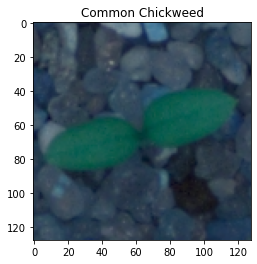

In [10]:
plt.imshow(data[2000])
plt.title(labels.iloc[2000,0])

Text(0.5, 1.0, 'Shepherds Purse')

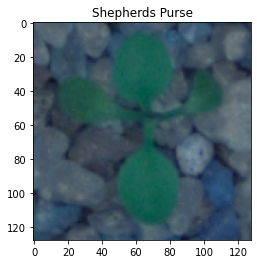

In [11]:
plt.imshow(data[1001])
plt.title(labels.iloc[1001,0])

### Applying Gausianblurr 3X3

In [12]:
blurr = [None]*len(data)
for i, img in enumerate(data):
    blurr[i] = cv2.GaussianBlur(img, (3, 3), 0)

Text(0.5, 1.0, 'Common Chickweed')

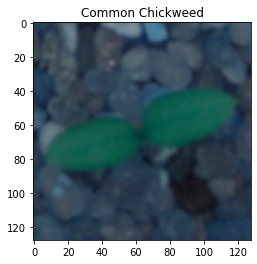

In [13]:
plt.imshow(blurr[2000])
plt.title(labels.iloc[2000,0])

#### Note: Upon several instances of training, it was found that applying GaussianBlur reduces the accuracy of all the ConvNets that were tried for this dataset.
#### Hence Gausianblurr is not considered for the traning and testing data. The above exectution is only show the implementation of GausBlur

## Encoding Labels

##### Will not be converting Labels to one-hot-encoding. I will use Sparse-Categorical-Crossentropy instead as my loss function. Which is same as using Categorical Cross entropy with one-hot-encoding.

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_le = le.fit_transform(labels)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [15]:
labels_le

array([10, 10, 10, ...,  6,  6,  6])

In [16]:
le.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

### Normalizing the data

In [17]:
data = data/255.0

### Create Train Test and Validation Set

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
xtr, xtsf, ytr, ytsf = train_test_split(data, labels_le, test_size=0.3, stratify=labels_le)

In [20]:
xts, xtv, yts, ytv = train_test_split(xtsf, ytsf, test_size=0.5, stratify=ytsf)

In [21]:
xtr.shape, xtv.shape, xts.shape

((3325, 128, 128, 3), (713, 128, 128, 3), (712, 128, 128, 3))

#### The shape of dataset is alreay in the format of (B, H,  W,  C)

### Data Augumentation

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    zca_whitening=False,
)

datagen.fit(data)

In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Concatenate, AvgPool2D, Dropout, Flatten, Dense, BatchNormalization, ReLU, Add,GlobalAvgPool2D
from tensorflow.keras.models import Model

## ANN Architectures

#### 1) Simple Model

In [25]:
# Implementation

In [ ]:
simple = Sequential([

    Conv2D(128,(7,7),input_shape=xtr.shape[1:]),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64,(3,3)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64,(3,3)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(50, activation="relu"),
    Dense(12, activation="softmax")
    
])

In [ ]:
simple.compile(optimizer="Adam", loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

history = simple.fit(xtr, ytr, epochs = 10000, batch_size=50, validation_data=(xtv,ytv), callbacks=tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True))

simple.save("Model_1")

In [26]:
simple = tf.keras.models.load_model("Model_1")

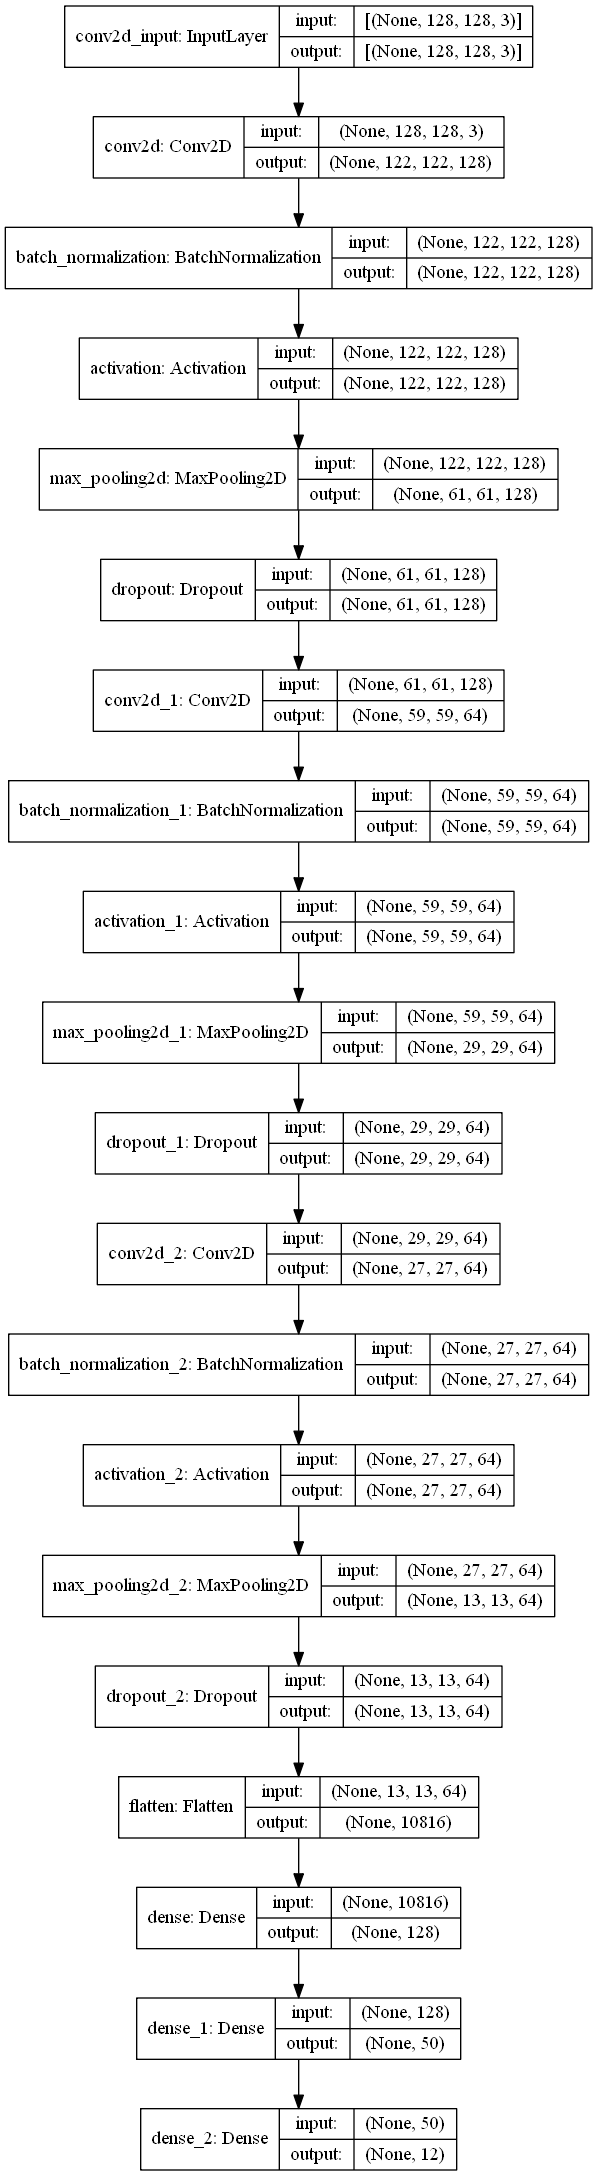

In [27]:
tf.keras.utils.plot_model(simple, show_shapes=True)

In [28]:
# Nodata augumentation was used for this run

In [29]:
simple.evaluate(xts,yts)

23/23 [==============================] - 5s 16ms/step - loss: 0.3552 - accuracy: 0.8778


[0.35517188906669617, 0.8778089880943298]

#### Data Augumentation using ImageDataGenerator was used for all the below models

#### 2) Slightly More Deep CNN with Data Augumentation

In [30]:
# Following Implementation Code in in RAW

In [ ]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

deep_aug = tf.keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=xtr.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    DefaultConv2D(filters=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.5),
    DefaultConv2D(filters=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=12, activation='softmax'),
])

In [ ]:
batch=32

deep_aug.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = deep_aug.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=1000, validation_data=(xtv, ytv), callbacks=tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), steps_per_epoch=len(xtr) // batch)

deep_aug.save("Model_2")

In [31]:
deep_aug = tf.keras.models.load_model("Model_2")

In [32]:
deep_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)      

In [33]:
deep_aug.evaluate(xts,yts)

23/23 [==============================] - 1s 16ms/step - loss: 0.3877 - accuracy: 0.8567


[0.3876984119415283, 0.8567415475845337]

#### 3) AlexNet

paper: https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

##### I will use BatchNormalization to replace LRN described in the paper. Keras has no direct implmentation for LRN.

In [34]:
# Implementation

In [ ]:

input_ = Input(shape=xtr.shape[1:])

x = Conv2D(96,(11,11), strides=4, padding="same", activation="relu") (input_)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
#2
x = Conv2D(256,(5,5), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
#3
x = Conv2D(384,(3,3), padding="same", activation="relu")(x)

#4
x = Conv2D(384,(3,3), padding="same", activation="relu")(x)

#5
x = Conv2D(256,(3,3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
#Dense
x = Flatten()(x)
x = Dense(units=4000, activation='relu')(x)
x = Dense(units=4000, activation='relu')(x)
x = Dropout(rate=0.5)(x)

output = Dense(units=12, activation='softmax')(x)

alexnet = Model(inputs=input_,outputs=output)

alexnet.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

batch=32

hist = alexnet.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=1000, validation_data=(xtv, ytv), callbacks=tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), steps_per_epoch=len(xtr) // batch)

alexnet.save("Model_3_AlexNet")

In [35]:
alexnet = tf.keras.models.load_model("Model_3_AlexNet")

In [36]:
alexnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 256)       614656    
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 15, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 256)         0     

In [37]:
alexnet.evaluate(xts,yts)

23/23 [==============================] - 1s 12ms/step - loss: 0.4514 - accuracy: 0.8357


[0.45135220885276794, 0.8356741666793823]

#### 4) VGG16 (D) Architecture

paper: https://arxiv.org/pdf/1409.1556.pdf

##### I have added BatchNormalization and Dropouts to avoid overfitting..

In [38]:
# Following Implementation Code in in RAW

In [ ]:
input_ = Input(shape=xtr.shape[1:])

x = Conv2D(64,(3,3),padding="same", activation="relu")(input_)
x = BatchNormalization()(x)
x = Conv2D(64,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2,padding="same")(x)
x = Dropout(rate=0.1)(x)

x = Conv2D(128,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(128,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2,padding="same")(x)
x = Dropout(rate=0.2)(x)

x = Conv2D(256,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(256,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(256,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2,padding="same")(x)
x = Dropout(rate=0.3)(x)

x = Conv2D(512,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(512,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(512,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2,padding="same")(x)
x = Dropout(rate=0.4)(x)

x = Conv2D(512,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(512,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2D(512,(3,3),padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2,padding="same")(x)
x = Dropout(rate=0.5)(x)

x = Flatten()(x)
x = Dense(4000, activation="relu")(x)
x = Dropout(rate=0.5)(x)
x = Dense(4000, activation="relu")(x)

output_ = Dense(12,activation="softmax")(x)

vgg16D = Model(inputs = input_,outputs=output_)

vgg16D.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist = vgg16D.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=1000, validation_data=(xtv, ytv), callbacks=tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), steps_per_epoch=len(xtr) // batch)

vgg16D.save("Model_4_VGG16")


In [39]:
vgg16D = tf.keras.models.load_model("Model_4_VGG16")

In [40]:
vgg16D.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 64)        0   

In [41]:
vgg16D.evaluate(xts,yts)

23/23 [==============================] - 3s 45ms/step - loss: 0.1285 - accuracy: 0.9382


[0.1285107284784317, 0.9382022619247437]

#### 5) Xception Architecture

paper: https://arxiv.org/pdf/1610.02357.pdf

In [42]:
# Following Implementation Code in in RAW

In [43]:
#Helper Functions

In [ ]:
def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

In [44]:
## Xception architecture uses Separable Convlution to boost the GoogleNet architecture

In [ ]:
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,kernel_size=kernel_size, strides=strides,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    t = ReLU()(x)
    
    x = sep_bn(t,filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x,filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    
    t = conv_bn(t, filters=128, kernel_size=1, strides=2)
    
    x = tf.keras.layers.concatenate([x,t])
    
    x = ReLU()(x)
    x = sep_bn(x,filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x,filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    
    t = conv_bn(t, filters=256, kernel_size=1, strides=2)
    
    x = tf.keras.layers.concatenate([x,t])
    
    x = ReLU()(x)
    x = sep_bn(x,filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x,filters=728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)
    
    t = conv_bn(t, filters=728, kernel_size=1, strides=2)
    
    x = tf.keras.layers.concatenate([x,t])
    
    return x
    

In [ ]:
def middle_flow(t):
    for _ in range(8):
        x = ReLU()(t)
        x = sep_bn(x,filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x,filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x,filters=728, kernel_size=3)
        
        t = tf.keras.layers.concatenate([x,t])
        
    return t

In [ ]:
def exit_flow(t):
    x = ReLU()(t)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
 
    t = conv_bn(t, filters=1024, kernel_size=1, strides=2)
 
    x = tf.keras.layers.concatenate([x,t])
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(units=12, activation='softmax')(x)
 
    return x
    

In [ ]:
input_ = Input(shape=xtr.shape[1:])
 
x = entry_flow(input_)
x = middle_flow(x)

output_ = exit_flow(x)

In [ ]:
xception = Model(input_, output_)

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tb_cb = tf. keras.callbacks.TensorBoard(log_dir=logdir)
es_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

In [ ]:
xception.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = xception.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=epochs, validation_data=(xtv, ytv), callbacks=[tb_cb,es_cb], steps_per_epoch=len(xtr) // batch)

xception.save("Model_5_xception")

In [46]:
xception = tf.keras.models.load_model("Model_5_xception")

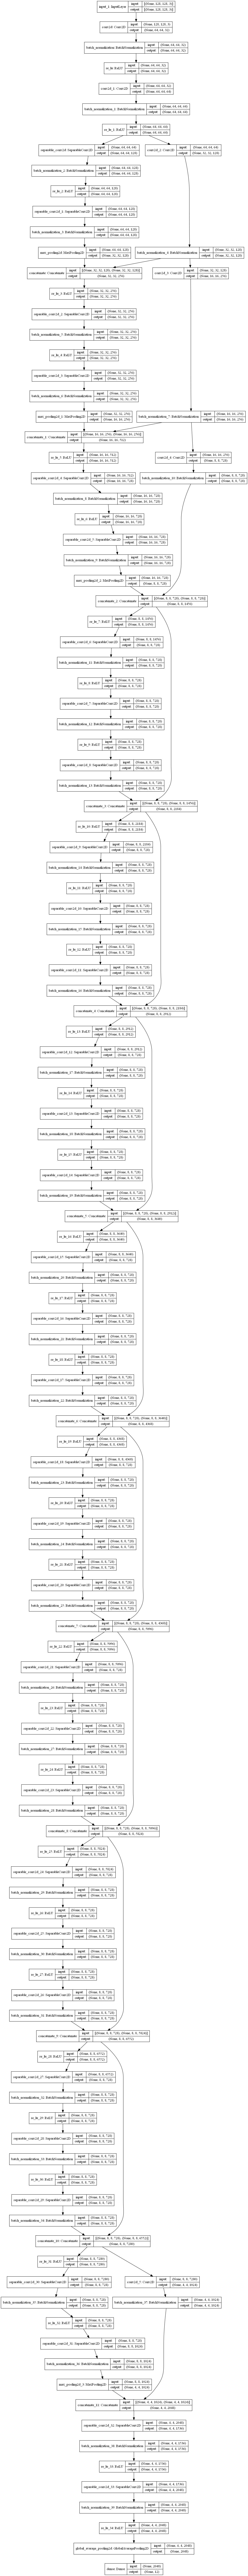

In [47]:
tf.keras.utils.plot_model(xception, show_shapes=True)

In [48]:
xception.evaluate(xts,yts)

23/23 [==============================] - 3s 65ms/step - loss: 0.0372 - accuracy: 0.9860


[0.03717973455786705, 0.9859550595283508]

#### 6) ResNet-50 Architecture

paper: https://arxiv.org/pdf/1512.03385.pdf

In [49]:
#Implementation:

In [ ]:
def conv_batchnorm_relu(x, filters, kernel_size, strides):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [ ]:
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)
 
    x = Add()([x, tensor])
    x = ReLU()(x)
    return x

In [ ]:
def projection_block(tensor, filters, strides):
    # left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides) #[v]
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)
 
    # right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)  # notice: filters=4*filters
    shortcut = BatchNormalization()(shortcut)
 
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [ ]:
def resnet_block(x, filters, reps, strides):
    x = projection_block(x, filters=filters, strides=strides)
    for _ in range(reps-1):
        x = identity_block(x, filters=filters)
    return x

In [ ]:
input_ = Input(shape=xtr.shape[1:])
 
x = conv_batchnorm_relu(input_, filters=64, kernel_size=7, strides=2)  # [3]: 7x7, 64, strides 2
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)  # [3]: 3x3 max mool, strides 2
 
x = resnet_block(x, filters=64, reps=3, strides=1)
x = resnet_block(x, filters=128, reps=4, strides=2)  # strides=2 ([2]: conv3_1)
x = resnet_block(x, filters=256, reps=6, strides=2)  # strides=2 ([2]: conv4_1)
x = resnet_block(x, filters=512, reps=3, strides=2)  # strides=2 ([2]: conv5_1)
 
x = GlobalAvgPool2D()(x)  # [3]: average pool *it is not written any pool size so we use Global
 
output_ = Dense(12, activation='softmax')(x)  # [3]: 1000-d fc, softmax
 
from tensorflow.keras import Model
 
resnet50 = Model(input_, output_)

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = tf. keras.callbacks.TensorBoard(log_dir=logdir)
es_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

In [ ]:
resnet50.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = resnet50.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=epochs, validation_data=(xtv, ytv), callbacks=[tb_cb,es_cb], steps_per_epoch=len(xtr) // batch)

In [ ]:
resnet50.save("Model_6_ResNet50")

In [50]:
resnet50 = tf.keras.models.load_model("Model_6_ResNet50")

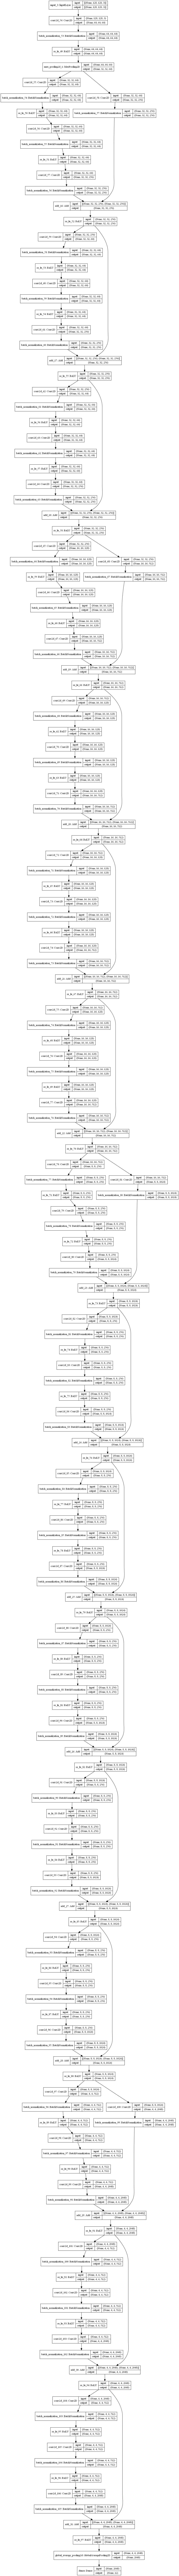

In [51]:
tf.keras.utils.plot_model(resnet50, show_shapes=True)

In [52]:
resnet50.evaluate(xts,yts)

23/23 [==============================] - 2s 35ms/step - loss: 0.1918 - accuracy: 0.9382


[0.19180089235305786, 0.9382022619247437]

#### 7) GoogLeNet Architecture

paper: https://arxiv.org/abs/1409.4842

In [53]:
#Implementation:

In [ ]:
def inception_block(x, filters):
    t1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)

    t2 = Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    t2 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(t2)

    t3 = Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    t3 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(t3)

    t4 = MaxPool2D(pool_size=3, strides=1, padding='same')(x)
    t4 = Conv2D(filters=filters[5], kernel_size=1, activation='relu')(t4)

    output = Concatenate()([t1, t2, t3, t4])
    
    return output

In [ ]:
input_ = Input(shape=xtr.shape[1:])

x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(input_)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = Conv2D(filters=64, kernel_size=1, activation='relu')(x)
x = Conv2D(filters=192, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=3, strides=2)(x)
x = Dropout(rate=0.2)(x)

x = inception_block(x, filters=[64, 96, 128, 16, 32, 32])
x = inception_block(x, filters=[128, 128, 192, 32, 96, 64])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
x = Dropout(rate=0.3)(x)

x = inception_block(x, filters=[192, 96, 208, 16, 48, 64])
x = inception_block(x, filters=[160, 112, 224, 24, 64, 64])
x = inception_block(x, filters=[128, 128, 256, 24, 64, 64])
x = inception_block(x, filters=[112, 144, 288, 32, 64, 64])
x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
x = Dropout(rate=0.4)(x)

x = inception_block(x, filters=[256, 160, 320, 32, 128, 128])
x = inception_block(x, filters=[384, 192, 384, 48, 128, 128])
x = AvgPool2D(pool_size=4, strides=1)(x)
x = Dropout(rate=0.5)(x)

x = Flatten()(x)
x = Dense(units=4000,activation="relu")(x)
x = Dropout(rate=0.4)(x)
x = Dense(units=2000, activation="relu")(x)

output_ = Dense(units=12, activation='softmax')(x)

googlenet = Model(inputs=input_, outputs=output_)

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tb_cb = tf. keras.callbacks.TensorBoard(log_dir=logdir)
es_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

In [ ]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001)

googlenet.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = googlenet.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=epochs, validation_data=(xtv, ytv), callbacks=[tb_cb,es_cb], steps_per_epoch=len(xtr) // batch)

In [ ]:
googlenet.save("Model_7_GoogLeNet")

In [54]:
googlenet = tf.keras.models.load_model("Model_7_GoogLeNet")

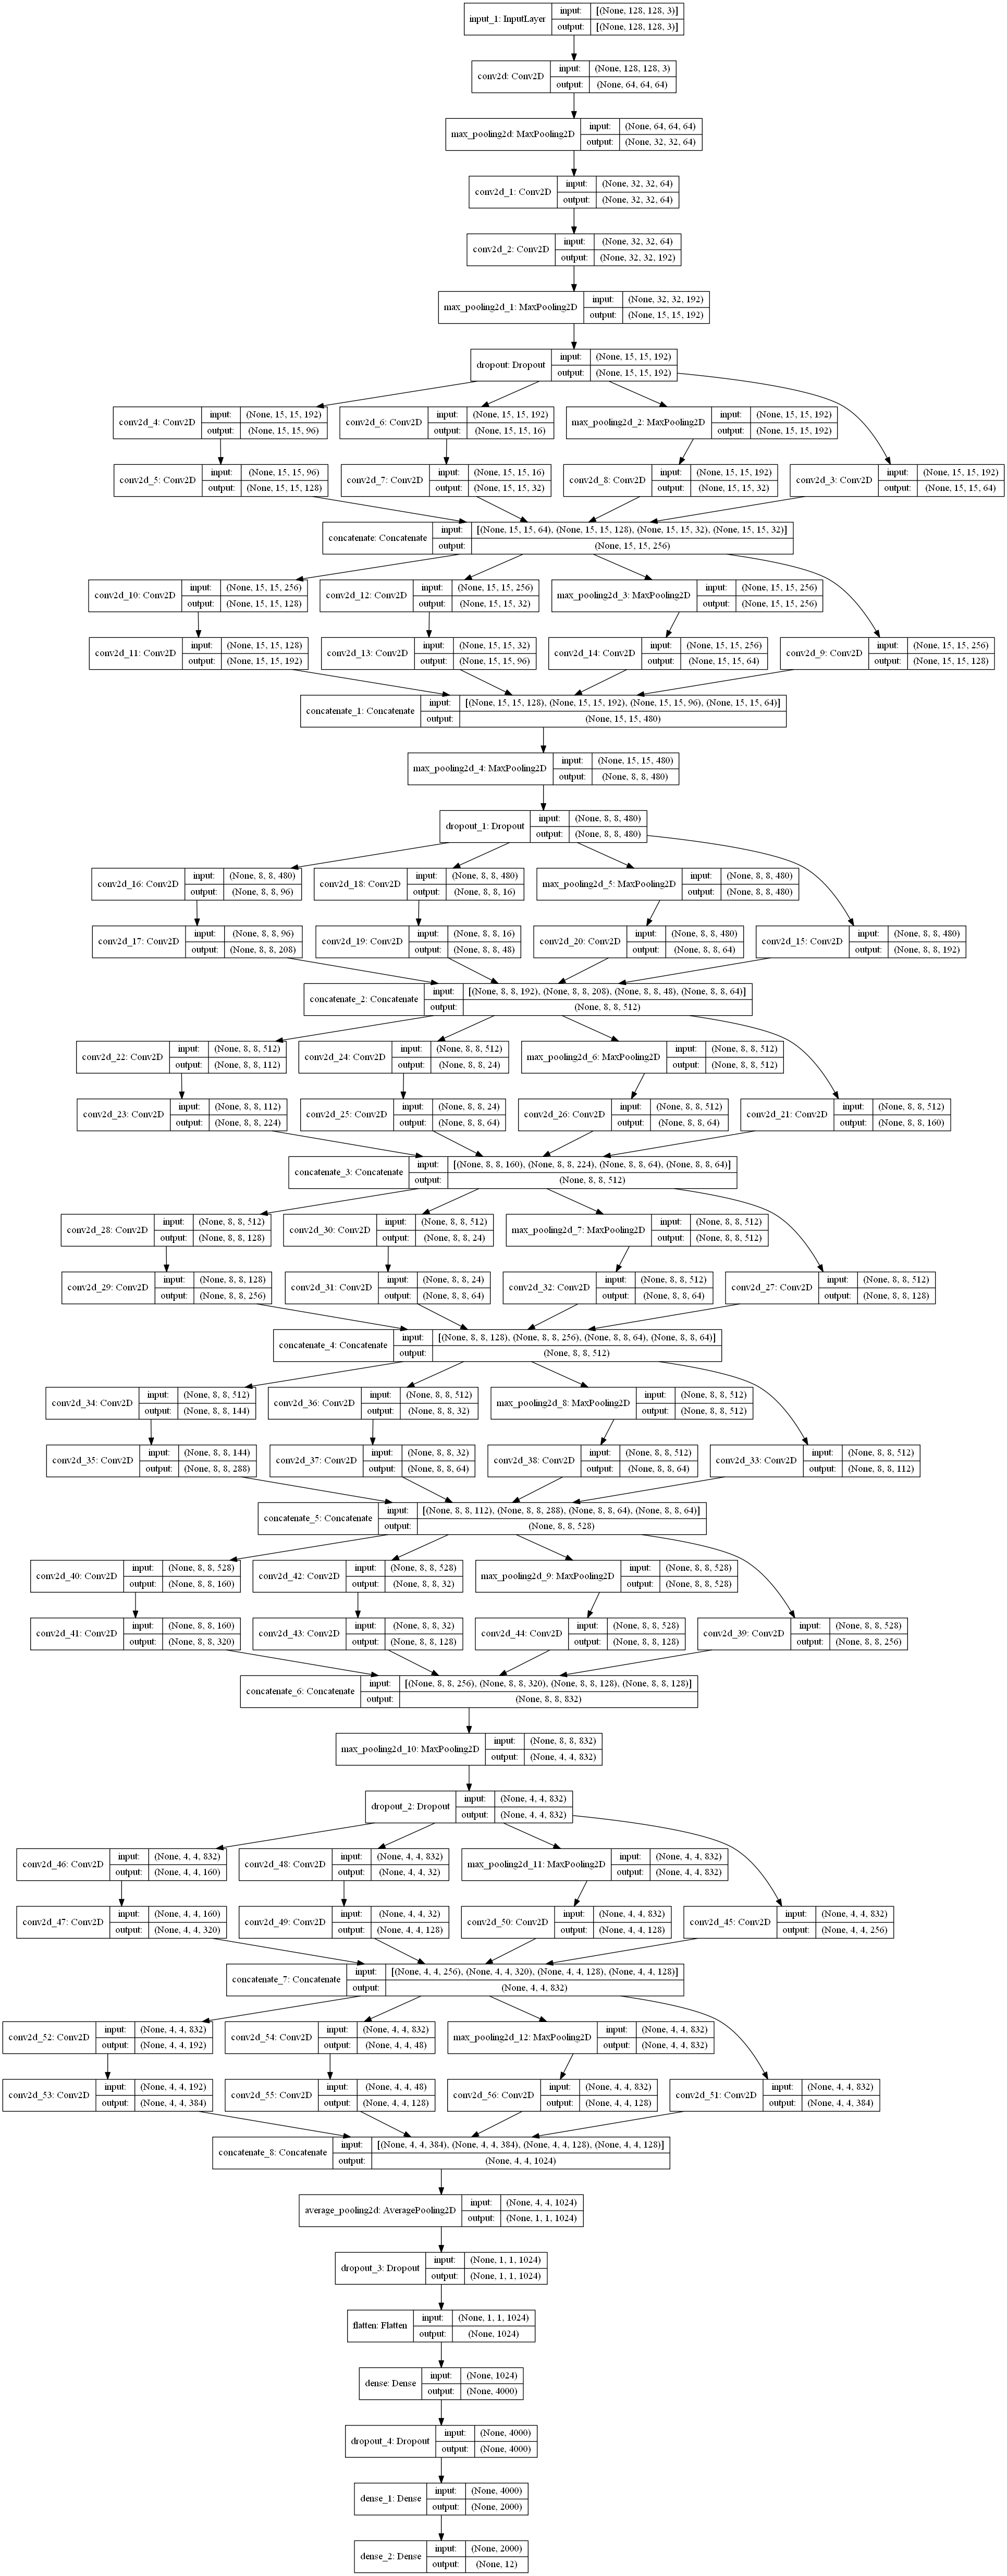

In [55]:
tf.keras.utils.plot_model(googlenet, show_shapes=True)

In [56]:
googlenet.evaluate(xts,yts)

23/23 [==============================] - 2s 43ms/step - loss: 0.3906 - accuracy: 0.8680


[0.3906034827232361, 0.867977499961853]

#### 8) Inception V3 - Transferlearning

##### This is a transfer learning attempt from InceptionV3 available in Keras trained over ImageNet

In [57]:
# Implementation:

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inceptv3 = InceptionV3(weights="imagenet",include_top=False)

In [ ]:
x = inceptv3.output
x = GlobalAvgPool2D()(x)

In [ ]:
x = Dense(1024,activation="relu")(x)
output_ = Dense(12,activation="softmax")(x)

In [ ]:
inceptv3_model = Model(inputs=inceptv3.input, outputs=output_)

In [ ]:
for layer in inceptv3.layers:
    layer.trainable = False

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = tf. keras.callbacks.TensorBoard(log_dir=logdir)
es_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

In [ ]:
opt = tf.keras.optimizers.RMSprop()
inceptv3_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = inceptv3_model.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=epochs, validation_data=(xtv, ytv), callbacks=[tb_cb,es_cb], steps_per_epoch=len(xtr) // batch)

In [ ]:
inceptv3_model.evaluate(xts,yts)

In [ ]:
for layer in inceptv3.layers[:172]:
    layer.trainable = False
for layer in inceptv3.layers[172:]:
    layer.trainable = True

In [ ]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001)

inceptv3_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = inceptv3_model.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=epochs, validation_data=(xtv, ytv), callbacks=[tb_cb,es_cb], steps_per_epoch=len(xtr) // batch)

In [ ]:
inceptv3_model.save("Model_8_InceptV3_Transfer")

In [58]:
inceptv3 = tf.keras.models.load_model("Model_8_InceptV3_Transfer")

In [59]:
tf.keras.utils.plot_model(inceptv3, show_shapes=True)

In [60]:
inceptv3.evaluate(xts,yts)

23/23 [==============================] - 3s 56ms/step - loss: 0.2184 - accuracy: 0.9270


[0.2184024304151535, 0.9269663095474243]

## Result Discussions

Plotting accuracy of the test set for all models

In [61]:
models = [simple, deep_aug, alexnet, vgg16D, xception, resnet50, googlenet, inceptv3]
modelstr = ["simple", "deep_aug", "alexnet", "vgg16D", "xception", "resnet50", "googlenet", "inceptv3"]

In [62]:
model_perform = pd.DataFrame(columns=["Model","Train_Accuracy","Validation_Accuracy","Test_Accuracy"], index=range(len(models))) 

In [63]:
i =0
for m in models:
    model_perform.iloc[i,0] = modelstr[i]
    model_perform.iloc[i,1] = models[i].evaluate(xtr,ytr)[1]
    model_perform.iloc[i,2] = models[i].evaluate(xtv,ytv)[1]
    model_perform.iloc[i,3] = models[i].evaluate(xts,yts)[1]
    i = i+1

23/23 [==============================] - 1s 31ms/step - loss: 0.2184 - accuracy: 0.9270


In [64]:
model_perform

Model Train_Accuracy Validation_Accuracy Test_Accuracy
0     simple       0.878797            0.879383      0.877809
1   deep_aug        0.84812            0.862553      0.856742
2    alexnet       0.834586            0.814867      0.835674
3     vgg16D       0.930827            0.934081      0.938202
4   xception       0.983459            0.987377      0.985955
5   resnet50       0.929323            0.917251      0.938202
6  googlenet       0.878195            0.880785      0.867977
7   inceptv3       0.924211            0.904628      0.926966

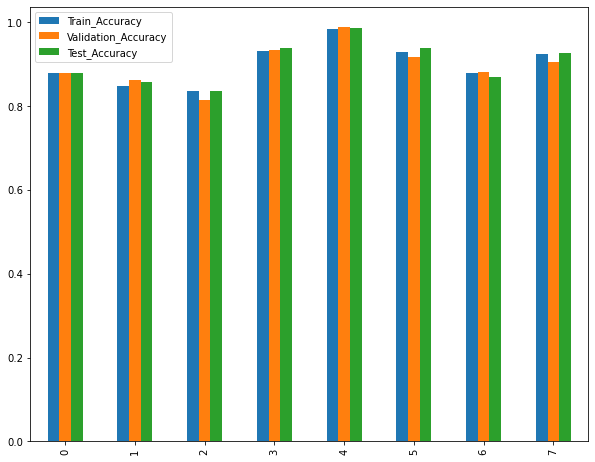

In [65]:
model_perform.plot(kind="bar",figsize=(10,8))
plt.show()

### Clearly Xception(#4) implementation has the heighest Score on the Test Set. And also it generilizes much better than other architectures.
### Hence, Xception will be choosen for prediction

In [66]:
#Creating Helper functions for prediction.

In [67]:
def predict_probas(model, X, n_samples=10):
  y_probs = [model.predict(X) for sample in range(n_samples)]
  return np.mean(y_probs, axis=0)

def predict_classes(model, X, n_samples=10):
  y_probs = predict_probas(model, X, n_samples)
  return np.argmax(y_probs, axis=1)

In [68]:
y_pred = predict_classes(xception, xts)

In [69]:
accuracy = np.mean(y_pred == yts)
accuracy

0.9859550561797753

The above accuracy value matches with as calculated from model.evaluate() which indicates the prediction helper function worked correctly

### Plotting Confusion Matrix

Text(0.5, 117.59999999999997, 'Predict')

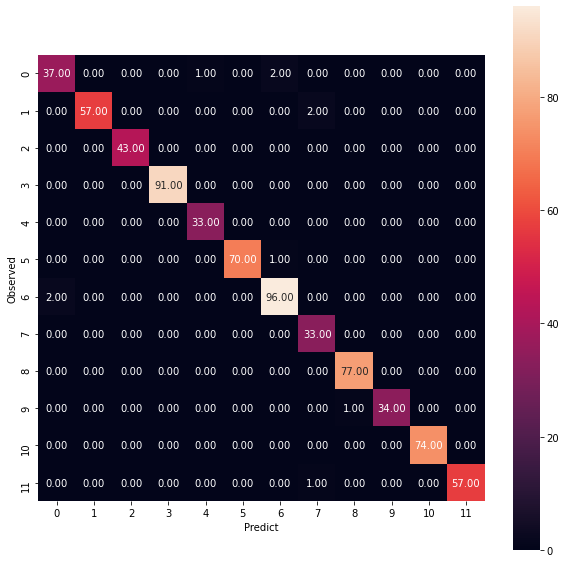

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(yts,y_pred),annot=True, fmt=".2f", xticklabels=range(12),yticklabels=range(12),square=True)
plt.ylabel("Observed")
plt.xlabel("Predict")

### Visualizing Predictions

In [71]:
y_pred_le = le.inverse_transform(y_pred)

In [72]:
yts_le = le.inverse_transform(yts)

In [73]:
def plot_pred(index):
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.axis("off")
    plt.imshow(xts[index])
    plt.title("Predicted Label: {}".format(y_pred_le[index]), fontsize=20)
    plt.subplot(122)
    plt.imshow(xts[index])
    plt.title("Ground Truth: {}".format(yts_le[index]), fontsize=20, color = "b")
    plt.axis("off")

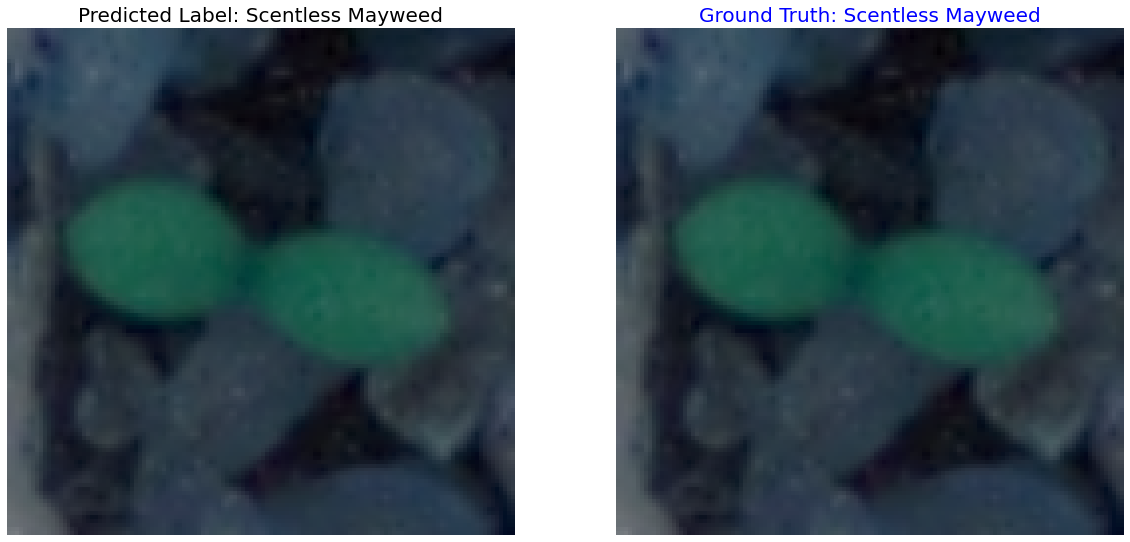

In [74]:
plot_pred(2)

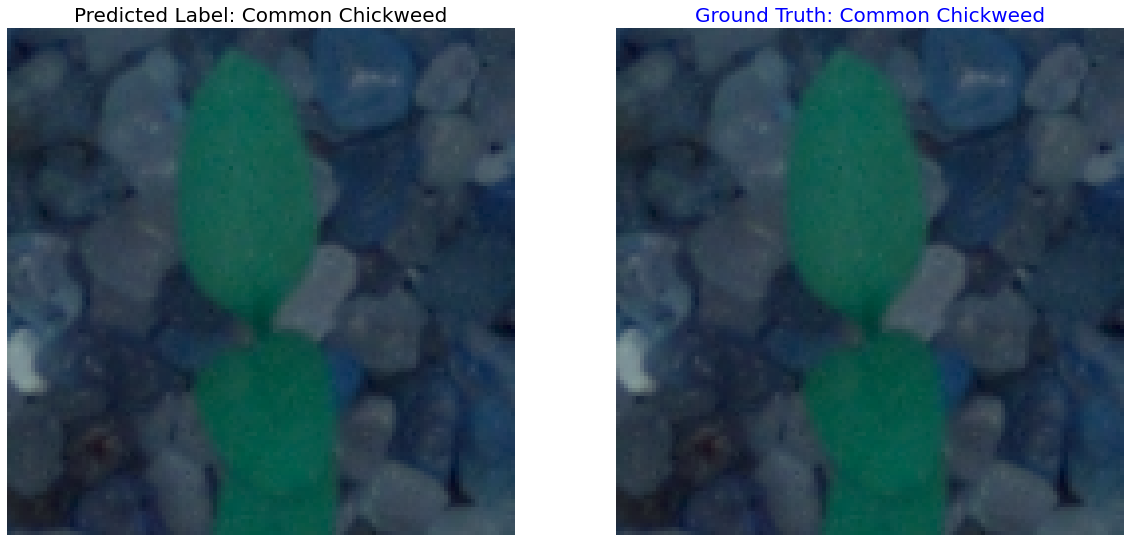

In [75]:
plot_pred(3)

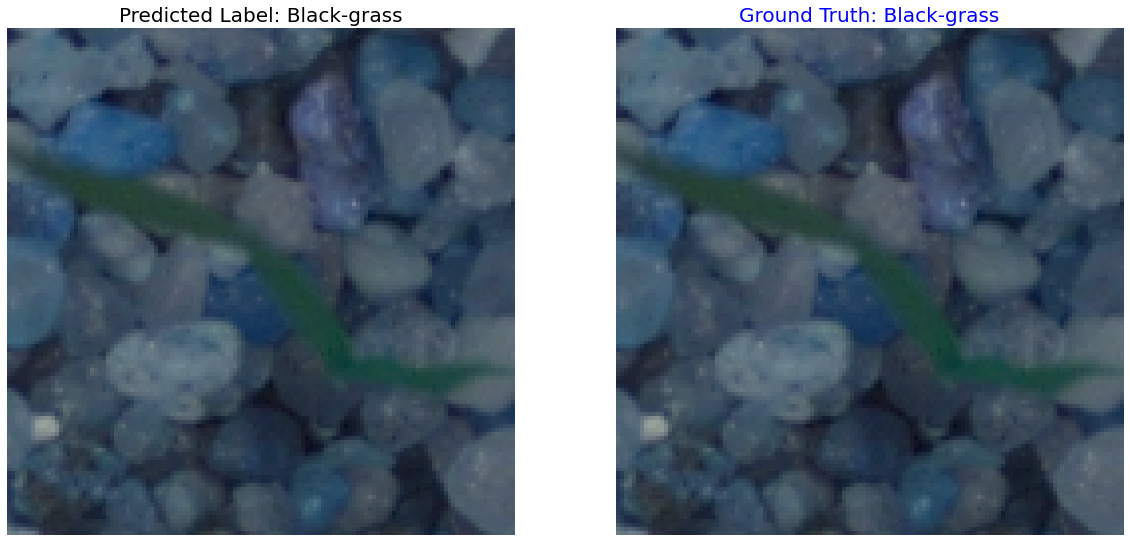

In [76]:
plot_pred(36)

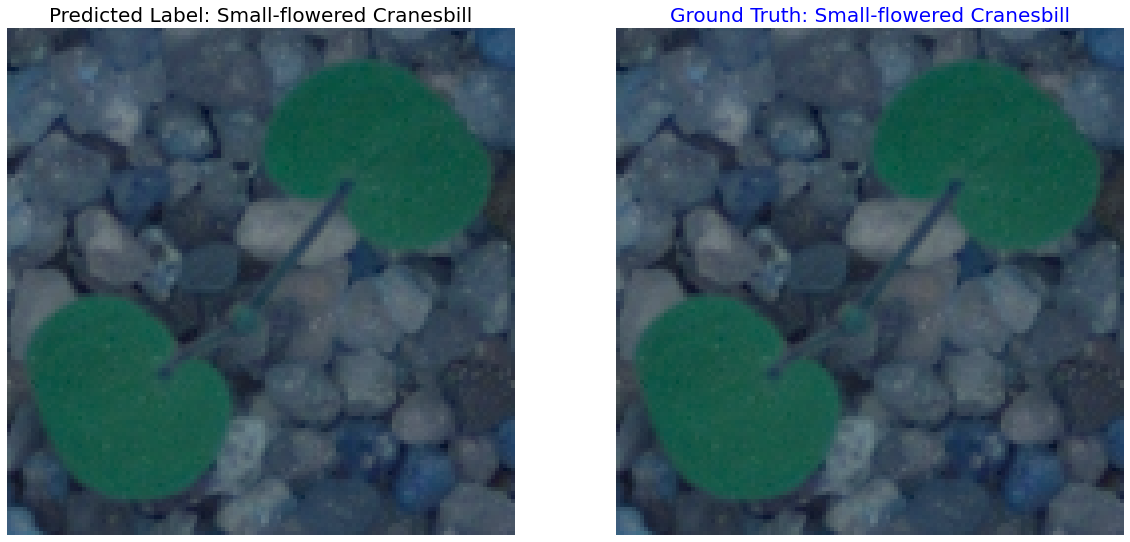

In [77]:
plot_pred(59)